# Energy Demand Forecasting with Granite Timeseries (TTM)

Based on the [Granite-Timeseries-TTM](https://github.com/ibm-granite/granite-tsfm/blob/cookbook-dev/notebooks/recipes/energy_demand_forecasting/demand_forecast_zeroshot_recipe.ipynb) notebook.

### Install the TSFM Library 

In [ ]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.8" -U

### Import Packages

In [2]:
import tsfm_public
import pandas as pd
tsfm_public.__version__

'0.2.8'

In [3]:
from tsfm_public import (
    TinyTimeMixerForPrediction,
    TimeSeriesForecastingPipeline,
)
# from tsfm_public.toolkit.visualization import plot_predictions
from tsfm_public.toolkit.time_series_preprocessor import create_timestamps

INFO:p-25190:t-8632406592:config.py:<module>:PyTorch version 2.2.2 available.


### Download the data

1. Download energy_data.csv.zip from Kaggle [here](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather)
2. Edit the `DATA_FILE_PATH` below to point to the data file.


In [4]:
DATA_FILE_PATH = "~/Downloads/energy_dataset.csv.zip"

### Specify time and output variables


In [5]:
timestamp_column = "time"
target_columns = ["total load actual"]
context_length = 512 # This is set by the pretrained model we will use.

### Read in the data

In [6]:
# Read in the data from the downloaded file.
input_df = pd.read_csv(
  DATA_FILE_PATH,
  parse_dates=[timestamp_column] # Convert the timestamp column to datetime format. 
)

# Fill NA/NaN values by propagating the last valid value.
input_df = input_df.ffill()

# Only use the last `context_length` rows for prediction.
input_df = input_df.iloc[-context_length:,]

# Show the last few rows of the dataset.
input_df.tail()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89
35063,2018-12-31 23:00:00+01:00,290.0,0.0,0.0,6926.0,2166.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3651.0,26.0,NaN,3117.0,24424.0,24455.0,64.27,69.88


### Plot a segment of the target series

In [ ]:
for target_column in target_columns:
  input_df.plot(x=timestamp_column, y=target_column, figsize=(20, 3))


### Set up zero shot model
The TTM model is hosted on [HuggingFace](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1).

In [8]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
  "ibm-granite/granite-timeseries-ttm-v1", # Name of the model on HuggingFace.
  num_input_channels=len(target_columns) # tsp.num_input_channels,
  # prediction_channel_indices=tsp.prediction_channel_indices,
)

### Create a forecasting pipeline

In [9]:
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    explode_forecasts=True,
    freq="h",
    device="cpu", # Specify your local GPU or CPU.
)

zeroshot_forecast = pipeline(input_df)
zeroshot_forecast.tail()

,time,total load actual_prediction
91,2019-01-04 18:00:00,31888.007812
92,2019-01-04 19:00:00,31953.996094
93,2019-01-04 20:00:00,31226.650391
94,2019-01-04 21:00:00,29632.423828
95,2019-01-04 22:00:00,27261.152344


### Plot predictions along with the historical data.

In [10]:
# plot_predictions function (to be moved into tsfm_public)

from typing import List, Optional
import matplotlib.pyplot as plt

def plot_zero_shot_predictions(
    input_df: pd.DataFrame,
    prediction: pd.DataFrame,
    timestamp_column: str,
    target_column: str,
    freq: str,
):
    """Utility for plotting forecasts along with history.

    Args:
        input_df: The input dataframe, containing timestamp and target columns
        predictions: The predictions dataframe, containing timestamp and prediction columns
        timestamp_column: Name of the timestamp column in input_df
        target_column: Name of the target column in input_df
        freq: Frequency of the time series data
    """

    # Pull out the prediction array from the predictions dataframe
    prediction_column = f"{target_column}_prediction"

    # Set a nice style for the plot
    plt.style.use("seaborn-v0_8-whitegrid")

    # Adjust figure size and subplot spacing
    fig, axs = plt.subplots(1, 1, figsize=(10, 3))

    # Set the length of the input series
    input_len = len(input_df)
    # Turn pandas series into numpy array
    input_ts_start = pd.to_datetime(input_df[timestamp_column].tail(input_len).iloc[0])
    # Get the start timestamp of the input data
    input_ts = create_timestamps(input_ts_start, freq=freq, periods=input_len) 
    input_y = input_df[target_column].tail(input_len).to_numpy()

    # Plot the historical data
    axs.plot(input_ts, input_y, label="Historical", linestyle="-", color="blue", linewidth=2)

    # Plot the prediction
    y_hat = prediction[prediction_column]
    pred_len = len(y_hat)
    ts = create_timestamps(prediction[timestamp_column].values[0], freq=freq, periods=pred_len)

    # Plot predicted values with a dashed line
    axs.plot(ts, y_hat, label="Predicted", linestyle="--", color="orange", linewidth=2)

    axs.set_title(f"Forecast")
    axs.legend()

    # Adjust overall layout
    plt.tight_layout()

512


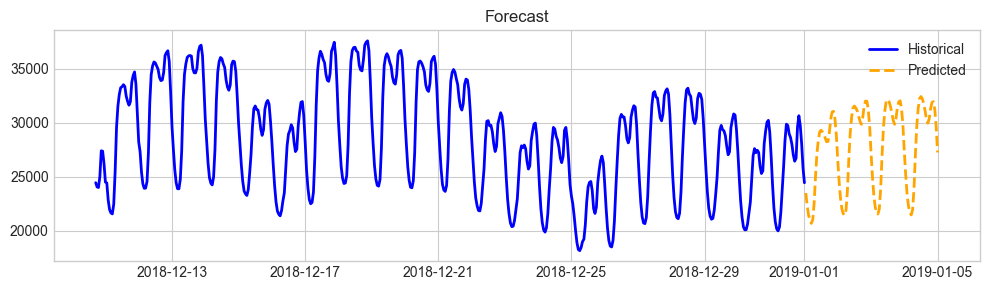

In [11]:
print(len(input_df))
pred = plot_zero_shot_predictions(
    input_df,
    zeroshot_forecast,
    timestamp_column=timestamp_column,
    target_column=target_column,
    freq="h",
)